<a href="https://colab.research.google.com/github/masher5764/GCN_Basic/blob/main/GCN_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Libraries**



In [ ]:
  !pip install torch-geometric # generate the Synthetic GRAPH

In [ ]:
# Standard libraries
import math
import time
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import RandomNodeSplit

# **Define Dataset**

In [ ]:
num_nodes_per_class = 100
num_nodes = [num_nodes_per_class] * 3   # [100, 100, 100]
edge_probs = [[0.1, 0.05, 0.02],
              [0.05, 0.1, 0.02],
              [0.02, 0.02, 0.1]]
dataset = StochasticBlockModelDataset('/content', num_nodes, edge_probs, num_channels=10)

In [ ]:
colors = cm.tab10.colors # form matplotlib 10 distinct colour
y_colors = np.array(colors)[dataset[0].y.numpy()] #  creates a NumPy array from the list of colors

In [ ]:
  dataset[0]  # Data(feature matrix = [300 nodes, (each) 10 features / dimensions], {COO (Coordinate List) format}edge_index =[4,840 edges , (each)2 values (source node and target node indices)], {vector for the nodes}y = [(1 label for each) 300 nodes])
              # Data(x=[300, 10],                                                   edge_index=[2, 4840],                                                                                           y=[300])

Data(x=[300, 10], edge_index=[2, 4840], y=[300])

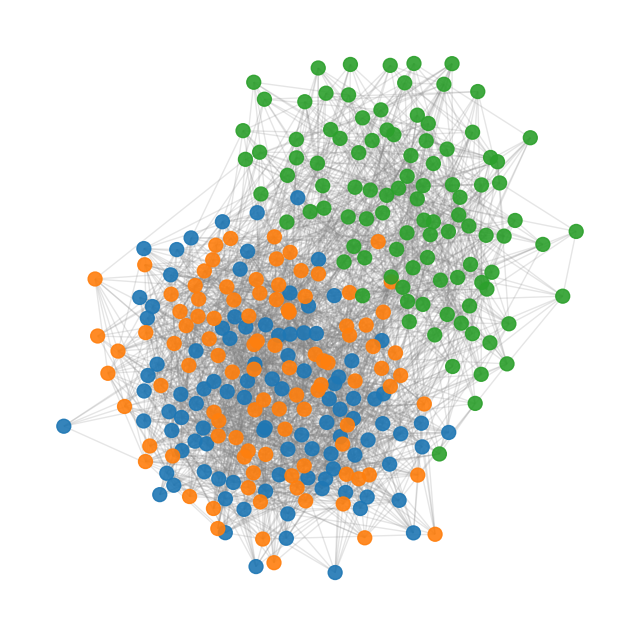

In [ ]:
# Plotting Graph Produced by Networkx
G = to_networkx(dataset[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G,
                pos=node_pos,
                node_size=100,
                node_color=y_colors,
                alpha=0.9
                )
nx.draw_networkx_edges(G,
                pos=node_pos,
                edge_color="grey",
                alpha=0.2
                )
plt.show()

# **Splitting**

In [ ]:
split = RandomNodeSplit(num_val=0.1, num_test=0.1)
data = split(dataset[0])
data

Data(x=[300, 10], edge_index=[2, 4840], y=[300], train_mask=[300], val_mask=[300], test_mask=[300])

# **GCN**

***Graph Convolution Layer***

In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):  #  uniform distribution
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)  # stdv is the inverse square root of the number of output features
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):  # adj -> describes which nodes are connected to which others
        support = torch.mm(input, self.weight) # input features are transformed into output features
        output = torch.spmm(adj, support) # actual graph convolution => sparse matrix multiplication
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

***Models***

In [ ]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid) # nfeat(Number of input features per node) = 10, nhid(the output of the first layer will have 3 features per node) = 3
        self.gc2 = GraphConvolution(nhid, nclass) # nhid = 3, nclass(Number of output classes) = 3
        self.dropout = dropout # dropout = Dropout rate used to regularize the model and prevent overfitting

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj)) # nfeat to nhid   # features[300 * 10] * weights[10 * 3] = support[300 * 3]
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj) #(num_nodes, nhid) -> (num_nodes, nclass)   # adj[300*300] * support[300 * 3] = output[300 * 3]
        return F.log_softmax(x, dim=1) # raw class scores into log probabilities over the nclass

# **Training**

In [ ]:
# normalized adjacency
adj = to_dense_adj(data.edge_index)[0] #  where each entry indicates whether there is an edge between two nodes

# symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
adj = adj + torch.eye(adj.shape[0]) # add self-loops to the adjacency matrix

# degree matrix
d = np.zeros((adj.shape[0],adj.shape[0])) #
np.fill_diagonal(d, adj.sum(1).numpy())
d = torch.from_numpy(d)
d_inv_sqrt = torch.pow(d, -0.5)

# set infinity values to zero
d_inv_sqrt = torch.nan_to_num(d_inv_sqrt, posinf=0.0)
d_inv_sqrt = d_inv_sqrt.to(dtype=torch.float32)

adj = (d_inv_sqrt @ adj) @ d_inv_sqrt # adj is now a normalized adjacency matrix

In [ ]:
features = data.x
features = nn.functional.normalize(features)
labels = data.y
idx_train = data.train_mask
idx_val = data.val_mask
idx_test = data.test_mask

In [ ]:
model = GCN(nfeat=features.shape[1],
            nhid=3, # Number of hidden units
            nclass=labels.max().item() + 1,
            dropout=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)

In [ ]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels) # here each row corresponds to a sample and each column is the predicted score (or log-probability) then for each sample, it finds the class with the highest predicted score
    correct = preds.eq(labels).double() # It returns a tensor of the same size as labels where each element is True if the prediction matches the label, and False otherwise.
    correct = correct.sum()
    return correct / len(labels)

In [ ]:
loss_train_list = []
loss_val_list = []

for epoch in range(2000):
    model.train()
    optimizer.zero_grad() # Forward Pass
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train]) #  Loss Calculation and Backpropagation
    loss_train_list.append(loss_train.item()) #  Appends the training loss for the current epoch
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    # Evaluate validation set performance separately,
    # deactivates dropout during validation run.
    model.eval()
    output = model(features, adj)
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    loss_val_list.append(loss_val.item())
    acc_val = accuracy(output[idx_val], labels[idx_val])

    # Print evaluation metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Train Acc: {acc_train.item()*100:.2f}% | Validation Acc: {acc_val.item()*100:.2f}%')

Epoch   0 | Train Acc: 32.92% | Validation Acc: 30.00%
Epoch  10 | Train Acc: 32.92% | Validation Acc: 30.00%
Epoch  20 | Train Acc: 54.58% | Validation Acc: 66.67%
Epoch  30 | Train Acc: 52.50% | Validation Acc: 66.67%
Epoch  40 | Train Acc: 61.25% | Validation Acc: 56.67%
Epoch  50 | Train Acc: 61.67% | Validation Acc: 56.67%
Epoch  60 | Train Acc: 66.25% | Validation Acc: 66.67%
Epoch  70 | Train Acc: 69.58% | Validation Acc: 63.33%
Epoch  80 | Train Acc: 70.00% | Validation Acc: 66.67%
Epoch  90 | Train Acc: 70.42% | Validation Acc: 66.67%
Epoch 100 | Train Acc: 71.67% | Validation Acc: 76.67%
Epoch 110 | Train Acc: 71.25% | Validation Acc: 73.33%
Epoch 120 | Train Acc: 70.42% | Validation Acc: 86.67%
Epoch 130 | Train Acc: 70.83% | Validation Acc: 73.33%
Epoch 140 | Train Acc: 72.50% | Validation Acc: 83.33%
Epoch 150 | Train Acc: 70.83% | Validation Acc: 86.67%
Epoch 160 | Train Acc: 73.33% | Validation Acc: 86.67%
Epoch 170 | Train Acc: 73.33% | Validation Acc: 90.00%
Epoch 180 

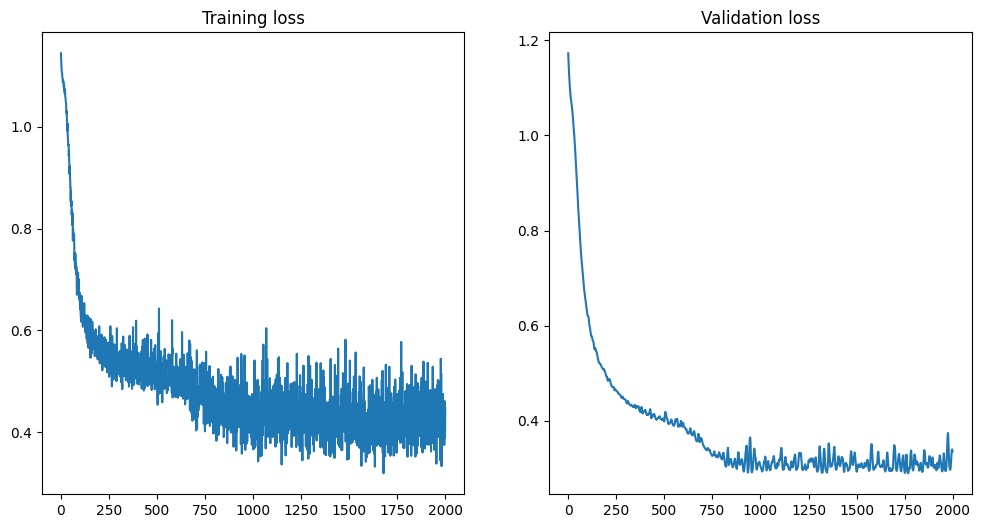

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(loss_train_list)
ax1.set_title('Training loss')
ax2.plot(loss_val_list)
ax2.set_title('Validation loss')
plt.show()

# **Testing**

In [ ]:
model.eval()
output = model(features, adj)
loss_test = F.nll_loss(output[idx_test], labels[idx_test])
idx_test_preds = output[idx_test].max(1)[1].type_as(labels)
acc_test = accuracy(output[idx_test], labels[idx_test])
print(f'Test Acc: {acc_test.item()*100:.2f}% | Test loss: {loss_test.item():.2f}')

Test Acc: 86.67% | Test loss: 0.31


***Missed Classified***

In [ ]:
torch.sum(labels[idx_test]!=idx_test_preds).item()

4

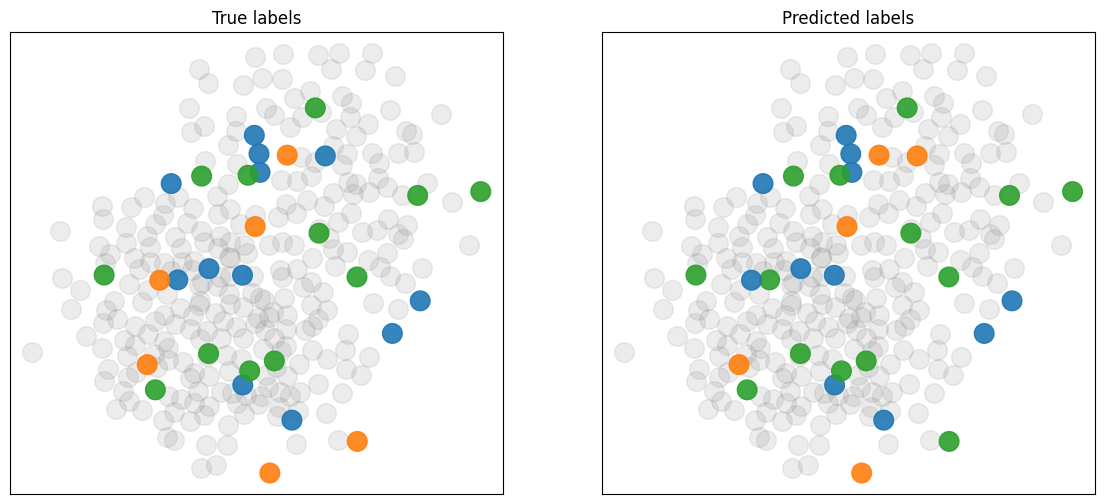

In [ ]:
G1 = nx.from_numpy_array(adj.numpy())
node_pos=nx.spring_layout(G, seed=0)

idx_train_nodes = np.nonzero(idx_train.numpy())[0]
idx_val_nodes = np.nonzero(idx_val.numpy())[0]
idx_test_nodes = np.nonzero(idx_test.numpy())[0]

idx_train_graph = G.subgraph(idx_train_nodes.tolist())
idx_val_graph = G.subgraph(idx_val_nodes.tolist())

idx_test_graph = G.subgraph(idx_test_nodes.tolist())
idx_test_graph_colors_true = np.array(colors)[labels[idx_test]]
idx_test_graph_colors_preds = np.array(colors)[idx_test_preds]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.set_title('True labels')
nx.draw_networkx_nodes(idx_train_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax1
                )
nx.draw_networkx_nodes(idx_val_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax1
                )
nx.draw_networkx_nodes(idx_test_graph,
                pos=node_pos,
                node_size=200,
                node_color=idx_test_graph_colors_true,
                alpha=0.9,
                ax = ax1
                )

ax2.set_title('Predicted labels')
nx.draw_networkx_nodes(idx_train_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax2
                )
nx.draw_networkx_nodes(idx_val_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15,
                ax = ax2
                )
nx.draw_networkx_nodes(idx_test_graph,
                pos=node_pos,
                node_size=200,
                node_color=idx_test_graph_colors_preds,
                alpha=0.9,
                ax = ax2
                )

plt.show()

In [ ]:
model

GCN(
  (gc1): GraphConvolution (10 -> 3)
  (gc2): GraphConvolution (3 -> 3)
)

In [ ]:
embeddings = F.relu(model.gc1(features, adj)).detach().numpy()
embeddings.shape

(300, 3)

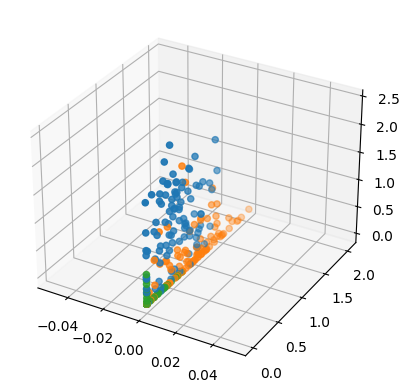

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2], color=y_colors)
plt.show()

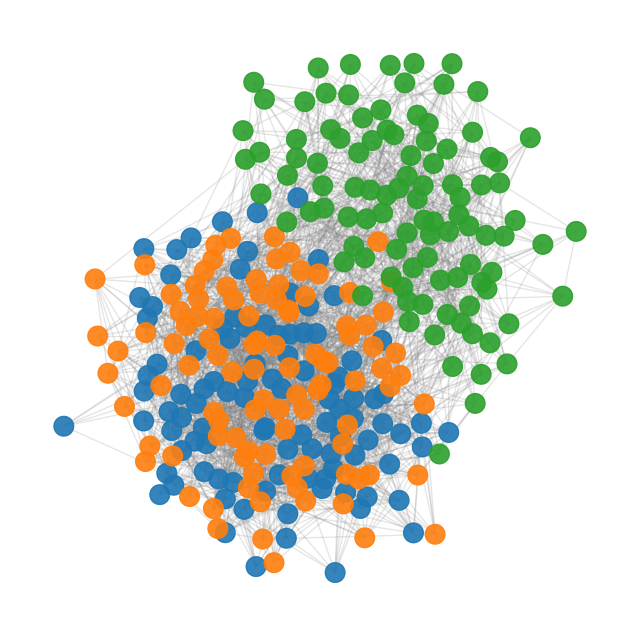

In [ ]:
G = to_networkx(dataset[0], to_undirected=True)
node_pos=nx.spring_layout(G, seed=0)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(G,
                pos=node_pos,
                node_size=200,
                node_color=y_colors,
                alpha=0.9
                )
nx.draw_networkx_edges(G,
                pos=node_pos,
                edge_color="grey",
                alpha=0.2
                )
plt.savefig('plot-01.png', bbox_inches='tight', dpi=600)

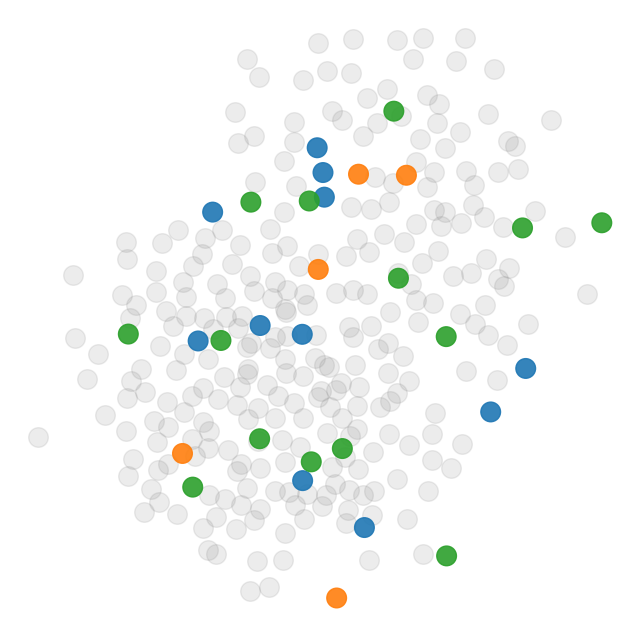

In [ ]:
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx_nodes(idx_train_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15
                )
nx.draw_networkx_nodes(idx_val_graph,
                pos=node_pos,
                node_size=200,
                node_color='grey',
                alpha=0.15
                )
nx.draw_networkx_nodes(idx_test_graph,
                pos=node_pos,
                node_size=200,
                node_color=idx_test_graph_colors_preds,
                alpha=0.9
                )

plt.savefig('plot-02.png', bbox_inches='tight', dpi=600)